In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
#!pip install tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


drive.mount('/content/drive')

#Get directory paths
base_dir = "/content/drive/MyDrive/ML_project_fall_25/dataset/"

# Update paths for your generators
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validate")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#read images from directory and process them in batches of BATCH_SIZE, resize to (224,224)
BATCH_SIZE = 64
target_size = (224,224) #this size is best for transfer learning

#dataset to read from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

num_classes = train_ds.element_spec[1].shape[-1]
class_names = train_ds.class_names
for i,name in enumerate(train_ds.class_names):
    print(f"{i}: {name}")
print("Number of Classes:", num_classes)


augment = tf.keras.Sequential([
    layers.RandomContrast(0.3),
    layers.RandomSaturation(0.3),
    layers.RandomHue(0.05)
])

def process_train(image, label):
    # training=True enables the random behavior (contrast, saturation, hue).
    return augment(image, training=True), label


#num_parallel_calls: dynamic setting that allows the TensorFlow runtime to determine the optimal number of elements to buffer based on the hardware (T4 GPU in our case)
train_ds = train_ds.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)

#cache and prefetch
#cache saves the result of previous transformations in memory to avoid redundant work in subsequent epochs
train_ds = train_ds.cache().shuffle(2000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 51387 files belonging to 15 classes.
Found 11008 files belonging to 15 classes.
Found 11012 files belonging to 15 classes.
0: apple fm train
1: apple fresh train
2: apple rotten train
3: banana fm train
4: banana fresh train
5: banana rotten train
6: grape fm train
7: grape fresh train
8: grape rotten train
9: mango fm train
10: mango fresh train
11: mango rotten train
12: orange fm train
13: orange fresh train
14: orange rotten train
Number of Classes: 15


In [10]:
#Transfer Learning - using EfficientNetB0 because its good for 224 x 224 and fast on T4 GPU

from tensorflow.keras.applications import EfficientNetB0

basemodel = EfficientNetB0(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
#for feature extraction
basemodel.trainable=False

In [28]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

inputs = layers.Input(shape=(224,224,3), dtype=tf.float32)
x = keras.applications.efficientnet.preprocess_input(inputs)
x = basemodel(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
model = models.Model(inputs,outputs)

In [29]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(0.00018791),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,482 (16.73 MB)

 Trainable params: 334,351 (1.28 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [30]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 100s 85ms/step - accuracy: 0.6332 - loss: 1.0936 - val_accuracy: 0.7050 - val_loss: 0.7682
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8457 - loss: 0.3946 - val_accuracy: 0.7072 - val_loss: 0.8780
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8767 - loss: 0.3173 - val_accuracy: 0.7063 - val_loss: 0.9255
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8900 - loss: 0.2809 - val_accuracy: 0.7259 - val_loss: 0.8726
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9039 - loss: 0.2537 - val_accuracy: 0.7243 - val_loss: 0.9608
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9094 - loss: 0.2363 - val_accuracy: 0.7358 - val_loss: 0.9168
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9152 - loss: 0.2223 - val_accuracy: 0.7489 - val_loss: 0.8616
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.9200 - loss: 0.2080 -

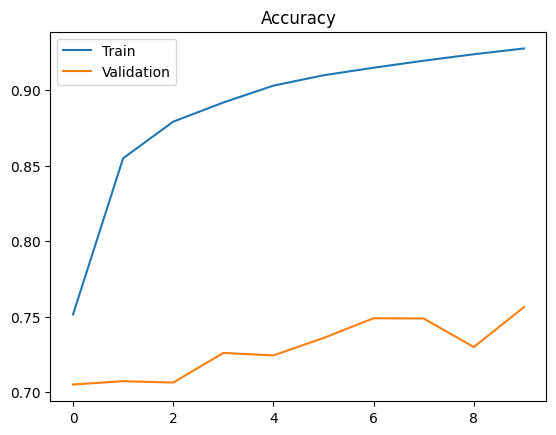

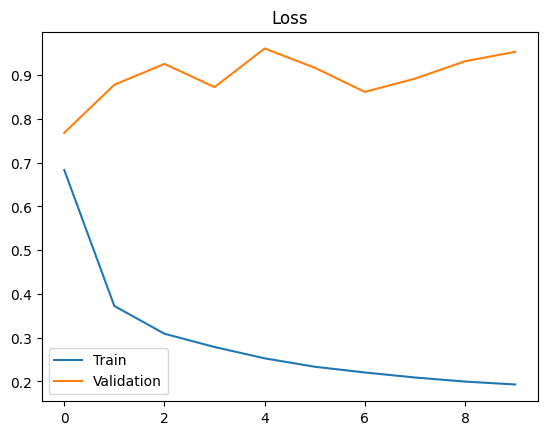

In [31]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train", "Validation"])
plt.show()

In [32]:
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)

print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7796 - loss: 0.7176
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.8143 - loss: 0.5608
Validation Accuracy: 0.7562681436538696
Test Accuracy: 0.8445332646369934


In [37]:
# Fine-tuning: Unfreeze the last 30% of the BASE model layers

basemodel.trainable = True

total_layers = len(basemodel.layers)
print("Total layers in base model:", total_layers)

unfreeze_amount = int(total_layers * 0.30)
print(f"Unfreezing the last {unfreeze_amount} layers.")


freeze_until = total_layers - unfreeze_amount
for layer in basemodel.layers[:freeze_until]:
    layer.trainable = False

Total layers in base model: 238
Unfreezing the last 71 layers.


In [38]:
#recompile the model with unfreezed
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), #use smaller training
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#CAN POSSIBLY TRAIN LONGER HERE
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,482 (16.73 MB)

 Trainable params: 3,413,483 (13.02 MB)

 Non-trainable params: 972,999 (3.71 MB)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 170s 129ms/step - accuracy: 0.7525 - loss: 0.7433 - val_accuracy: 0.7162 - val_loss: 0.9524
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.8756 - loss: 0.3370 - val_accuracy: 0.7257 - val_loss: 0.9897
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9051 - loss: 0.2551 - val_accuracy: 0.7466 - val_loss: 1.0066
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9228 - loss: 0.2039 - val_accuracy: 0.7450 - val_loss: 1.0237
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9358 - loss: 0.1764 - val_accuracy: 0.7614 - val_loss: 1.0360
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9444 - loss: 0.1497 - val_accuracy: 0.7646 - val_loss: 1.0858
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.9530 - loss: 0.1268 - val_accuracy: 0.7674 - val_loss: 1.0961
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.9578 - loss: 0.1171 

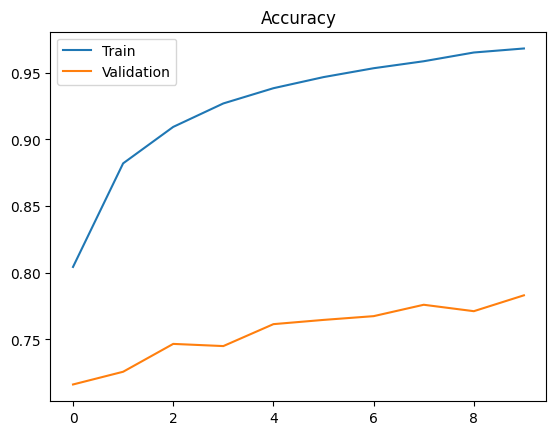

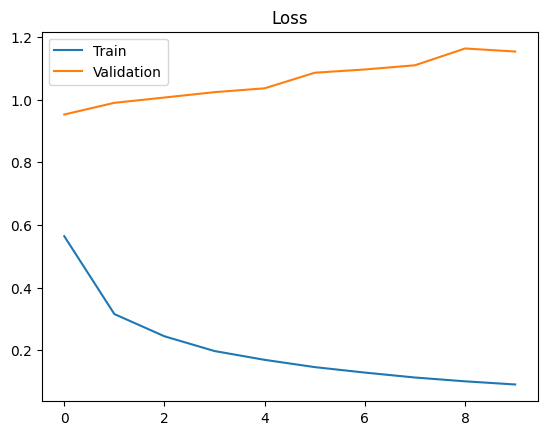

In [39]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train", "Validation"])
plt.show()

In [40]:
from sklearn.metrics import classification_report
# Collect predictions
y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y.numpy(), axis=1))

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━

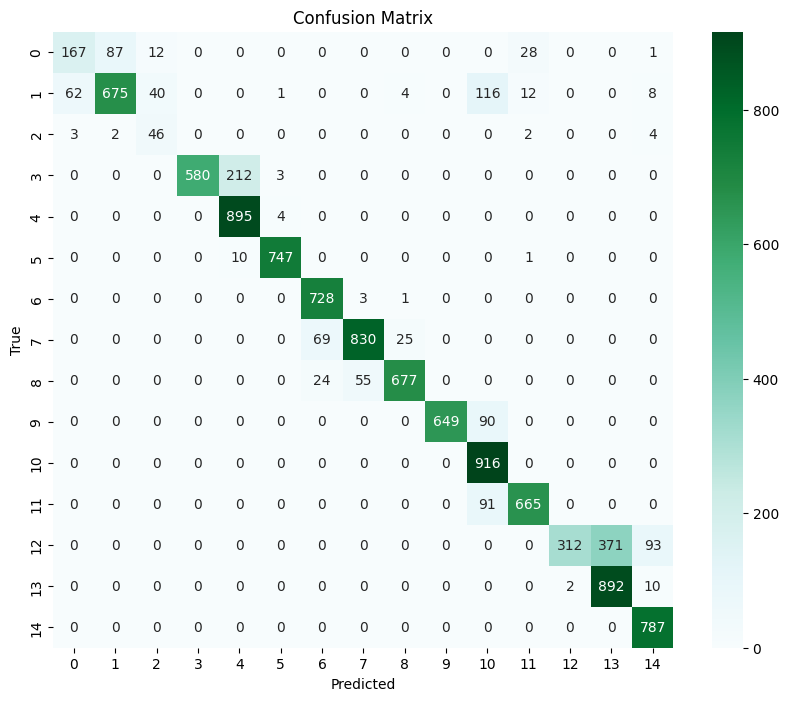

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#class 0,3,12 (apple/banana/orange fm) gets confused with class 1,4,13(apple,banana,orange fresh)
#apple rotten isn't getting read for some reason. THere are only ~50 instances even tho there are more

In [ ]:
model.save("final_pretrained_model.keras")